In [1]:
import pandas as pd
import numpy as np

In [57]:
import statsmodels.api as sm

### Import Data

In [2]:
data_directory = "data/"
file = "yahoo_data_filter_0_1.csv"

In [3]:
df = pd.read_csv(data_directory+file)
df.index = pd.to_datetime(df.iloc[:,0])
df = df.iloc[:,1:]

In [100]:
asset_list = list(df.columns)

In [119]:
asset_list[1]

'ADX-USD'

In [120]:
asset = "ADX-USD"

In [121]:
asset_series = df[asset]

### Calculate Signal

In [122]:
momentum_period = 3
waiting_period = 1

In [123]:
signal_series = asset_series.pct_change(momentum_period).shift(waiting_period).dropna()

### Calculate Return

In [124]:
future_ret_days = 1

In [125]:
target_series = asset_series.pct_change(future_ret_days).shift(-(future_ret_days-1))

### Merge the dataframe

In [126]:
merge_df = pd.concat([target_series,signal_series],axis=1)

In [127]:
merge_df = merge_df.dropna()

In [128]:
merge_df.columns = ["target","signal"]

### Regression Analysis

In [129]:
exog = ["signal"]
depe = ["target"]

In [130]:
depe_var = merge_df[depe]
exog_var = merge_df[exog]
exog_var = sm.add_constant(exog_var)

In [131]:
mod = sm.OLS(depe_var,exog_var)
result = mod.fit()

In [132]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     21.01
Date:                Sat, 09 Jan 2021   Prob (F-statistic):           5.09e-06
Time:                        16:29:32   Log-Likelihood:                 1090.5
No. Observations:                1093   AIC:                            -2177.
Df Residuals:                    1091   BIC:                            -2167.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.758      0.448      -0.003       0.007
signal        -0.0917      0.020     -4.584      0.000      -0.131      -0.052
==============================================================================
Omnibus:                      751.840   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25775.722
Skew:                           2.683   Prob(JB):                         0.00
Kurtosis:                      26.178   Cond. No.                         7.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
result = result.get_robustcov_results(cov_type="HAC",maxlags=6)

In [134]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     15.31
Date:                Sat, 09 Jan 2021   Prob (F-statistic):           9.69e-05
Time:                        16:29:33   Log-Likelihood:                 1090.5
No. Observations:                1093   AIC:                            -2177.
Df Residuals:                    1091   BIC:                            -2167.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.788      0.431      -0.003       0.007
signal        -0.0917      0.023     -3.913      0.000      -0.138      -0.046
==============================================================================
Omnibus:                      751.840   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25775.722
Skew:                           2.683   Prob(JB):                         0.00
Kurtosis:                      26.178   Cond. No.                         7.40
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
"""

### All Asset Analysis

In [138]:
momentum_period = 3
waiting_period = 1
future_ret_days = 1


depe = ["target"]
exog = ["signal"]

In [145]:
result_list = []

for asset in asset_list:
    
    asset_series = df[asset]
    
    signal_series = asset_series.pct_change(momentum_period).shift(waiting_period).dropna()
    target_series = asset_series.pct_change(future_ret_days).shift(-(future_ret_days-1))
    
    merge_df = pd.concat([target_series,signal_series],axis=1)
    merge_df = merge_df.dropna()
    merge_df.columns = ["target","signal"]
    
    depe_var = merge_df[depe]
    exog_var = merge_df[exog]
    exog_var = sm.add_constant(exog_var)
    
    mod = sm.OLS(depe_var,exog_var)
    result = mod.fit()
    summary = result.summary()
    
    result_list.append((asset,result,summary))


### Strategy Return Analysis

In [200]:
asset_list[2]

'AE-USD'

In [167]:
momentum_period = 3
waiting_period = 1
future_ret_days = 1

In [201]:
asset = "AE-USD"

In [202]:
asset_series = df[asset]

In [203]:
threshold = 0.1

In [204]:
signal_series = asset_series.pct_change(momentum_period).shift(waiting_period).dropna()
target_series = asset_series.pct_change(future_ret_days).shift(-(future_ret_days-1))
    
merge_df = pd.concat([target_series,signal_series],axis=1)
merge_df = merge_df.dropna()
merge_df.columns = ["target","signal"]

In [205]:
merge_df["position"] = 0

In [206]:
merge_df["position"][merge_df["signal"]>threshold] = 1

<ipython-input-206-c2c86ce19d0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["position"][merge_df["signal"]>threshold] = 1


In [207]:
merge_df["strategy_ret"] = merge_df["position"] * merge_df["target"]

In [208]:
merge_df["strategy_cum"] = (merge_df["strategy_ret"]+1).cumprod()

<AxesSubplot:xlabel='date'>

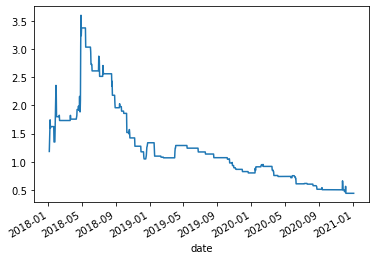

In [209]:
merge_df["strategy_cum"].plot()